# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [3]:
import os
import numpy as np
import time
import itertools
from scipy.spatial.distance import pdist 
from functools import partial
import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool
import pandas as pd
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging, Constant)
from ema_workbench.analysis import parcoords

from ema_workbench.util.utilities import load_results


In [ ]:
save_results((selected_experiments, selected_outcomes), './results/selected_results.tar.gz')

Loading the results: The results from assignment 8 which have been saved under the file 'selected_results.tar.gz' are first loaded

In [2]:
selected_results = load_results('./results/selected_results.tar.gz')

In [165]:
# The experiments are in the first index of selected results, while the outcomes are in the second index

selected_experiments = selected_results[0]
selected_outcomes = selected_results[1]

In [4]:
selected_results[0]

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,policy,model
0,0.249255,0.950646,0.023808,2.735874,0.003896,0.25242,0.246175,0.679096,1.414136,0.926365,Policy 4,lakeproblem
1,0.424307,0.942486,0.015946,4.381926,0.003912,0.25242,0.246175,0.679096,1.414136,0.926365,Policy 4,lakeproblem
2,0.411548,0.959701,0.022737,2.826762,0.004578,0.25242,0.246175,0.679096,1.414136,0.926365,Policy 4,lakeproblem
3,0.425041,0.937087,0.041664,2.238307,0.003665,0.25242,0.246175,0.679096,1.414136,0.926365,Policy 4,lakeproblem
4,0.387669,0.941614,0.033641,3.641711,0.002912,0.25242,0.246175,0.679096,1.414136,0.926365,Policy 4,lakeproblem
...,...,...,...,...,...,...,...,...,...,...,...,...
310,0.277988,0.962823,0.023494,4.442463,0.001553,0.25242,0.246175,0.679096,1.414136,0.926365,Policy 4,lakeproblem
311,0.331508,0.959189,0.034092,3.412294,0.001187,0.25242,0.246175,0.679096,1.414136,0.926365,Policy 4,lakeproblem
312,0.361447,0.969176,0.027242,2.579616,0.002465,0.25242,0.246175,0.679096,1.414136,0.926365,Policy 4,lakeproblem
313,0.381451,0.956642,0.027336,3.381344,0.003099,0.25242,0.246175,0.679096,1.414136,0.926365,Policy 4,lakeproblem


In [5]:
# These results have to be combined into one large dataframe, which can be used to determine the reference variables of the policies

selected_outcomes_DF = pd.DataFrame(selected_outcomes)
selected_experiments

# Concatenate into one large dataframe

selected_dataframe = pd.concat([selected_experiments, selected_outcomes_DF], axis=1)

print(selected_dataframe)

            b     delta      mean         q     stdev       c1        c2  \
0    0.249255  0.950646  0.023808  2.735874  0.003896  0.25242  0.246175   
1    0.424307  0.942486  0.015946  4.381926  0.003912  0.25242  0.246175   
2    0.411548  0.959701  0.022737  2.826762  0.004578  0.25242  0.246175   
3    0.425041  0.937087  0.041664  2.238307  0.003665  0.25242  0.246175   
4    0.387669  0.941614  0.033641  3.641711  0.002912  0.25242  0.246175   
..        ...       ...       ...       ...       ...      ...       ...   
310  0.277988  0.962823  0.023494  4.442463  0.001553  0.25242  0.246175   
311  0.331508  0.959189  0.034092  3.412294  0.001187  0.25242  0.246175   
312  0.361447  0.969176  0.027242  2.579616  0.002465  0.25242  0.246175   
313  0.381451  0.956642  0.027336  3.381344  0.003099  0.25242  0.246175   
314  0.399406  0.937388  0.016987  3.038855  0.003738  0.25242  0.246175   

           r1        r2        w1    policy        model     max_P   utility  \
0    0.

# Search for each scenario
For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small).

Store the resulting set of pareto solutions in a smart way for subsequent analysis.

In [6]:
# Choose 4 policies, these will be based on the worst-case scenarios for Max_P, Utility, Inertia and Reliability

from ema_workbench import Policy

# The dataframe is sorted for each criteria and the worst-case scenario is taken.
max_P_sort = selected_dataframe.sort_values(by = "max_P", ascending = False)
max_P_worst = pd.DataFrame(max_P_sort.iloc[0,:]).T

utility_sort = selected_dataframe.sort_values(by = "utility")
utility_worst = pd.DataFrame(utility_sort.iloc[0,:]).T

inertia_sort = selected_dataframe.sort_values(by = "inertia")
inertia_worst = pd.DataFrame(inertia_sort.iloc[1,:]).T

reliability_sort = selected_dataframe.sort_values(by = "reliability")
reliability_worst = pd.DataFrame(reliability_sort.iloc[0,:]).T

chosen_policies = pd.concat([max_P_worst, utility_worst, inertia_worst, reliability_worst], axis = 0)
chosen_policy_levers = chosen_policies.iloc[:,5:10]

chosen_four_policies = []

for i in range(len(chosen_policy_levers)):
    chosen_policy = Policy(name = "Policy " + str(i),
                           c1 = chosen_policy_levers.iloc[i,0],
                           c2 = chosen_policy_levers.iloc[i,1],
                           r1 = chosen_policy_levers.iloc[i,2],
                           r2 = chosen_policy_levers.iloc[i,3],
                           w1 = chosen_policy_levers.iloc[i,4])
    chosen_four_policies.append(chosen_policy)

chosen_four_policies

chosen_policies

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,policy,model,max_P,utility,inertia,reliability
115,0.249687,0.931735,0.0379153,2.58729,0.00353775,0.25242,0.246175,0.679096,1.41414,0.926365,Policy 4,lakeproblem,4.47711,0.214279,0.9721,0.2108
113,0.354727,0.930411,0.0411475,4.45467,0.00369858,0.25242,0.246175,0.679096,1.41414,0.926365,Policy 4,lakeproblem,0.14594,0.10858,0.99,1
169,0.266276,0.933881,0.0218779,2.2476,0.00121567,0.25242,0.246175,0.679096,1.41414,0.926365,Policy 4,lakeproblem,4.05886,0.147469,0.9715,0.3686
148,0.278913,0.954815,0.0439075,2.49842,0.00179195,0.25242,0.246175,0.679096,1.41414,0.926365,Policy 4,lakeproblem,3.9925,0.438306,0.9714,0.1916


In [7]:
# Reference scnearios are created based on the chosen policies. The b, delta, mean, q and stdev of these scenarios are set as reference values.

from ema_workbench import Scenario

reference_Max_P = Scenario('max_P_WC', b=chosen_policies.iloc[0,0], delta = chosen_policies.iloc[0,1], mean=chosen_policies.iloc[0,2], q=chosen_policies.iloc[0,3], stdev=chosen_policies.iloc[0,4])
reference_Utility = Scenario('Utility_WC', b=chosen_policies.iloc[1,0], delta = chosen_policies.iloc[1,1], mean=chosen_policies.iloc[1,2], q=chosen_policies.iloc[1,3], stdev=chosen_policies.iloc[1,4])
reference_Inertia = Scenario('Inertia_WC', b=chosen_policies.iloc[2,0], delta = chosen_policies.iloc[2,1], mean=chosen_policies.iloc[2,2], q=chosen_policies.iloc[2,3], stdev=chosen_policies.iloc[2,4])
reference_Reliability = Scenario('Reliability_WC', b=chosen_policies.iloc[3,0], delta = chosen_policies.iloc[3,1], mean=chosen_policies.iloc[3,2], q=chosen_policies.iloc[3,3], stdev=chosen_policies.iloc[3,4])


In [8]:
# Set up the experiments again

from dps_lake_model import lake_model, get_antropogenic_release

from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging, Constant)
from ema_workbench.analysis import parcoords
from ema_workbench.util.utilities import load_results, save_results

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
mordm_lake_model = Model('lakeproblem', function=lake_model)
mordm_lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
mordm_lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
mordm_lake_model.levers = [RealParameter('c1', -2, 2),
                    RealParameter('c2', -2, 2),
                    RealParameter('r1', 0, 2),
                    RealParameter('r2', 0, 2),
                    RealParameter('w1', 0, 1)] 

#specify outcomes 
mordm_lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

mordm_lake_model.constantcs = [Constant('alpha', 0.41),
                         Constant('reps', 150)],

In [121]:
with MultiprocessingEvaluator(mordm_lake_model) as evaluator:
    results_Max_P = evaluator.optimize(nfe=1000, epsilons=[0.01, 0.01, 0.01, 0.01], reference=reference_Max_P, searchover = 'levers')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 496/1000 nfe
[MainProcess/INFO] generation 10: 993/1000 nfe
[MainProcess/INFO] optimization completed, found 21 solutions
[MainProcess/INFO] terminating pool


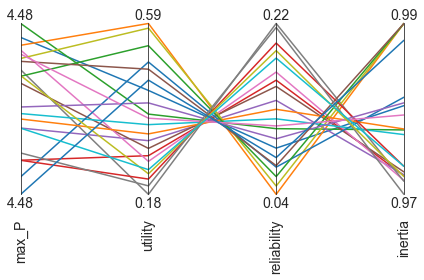

In [122]:
outcomes = results_Max_P.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 

In [11]:
from ema_workbench import Constraint
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

#specify outcomes 
mordm_lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(mordm_lake_model.outcomes),
                       EpsilonProgress()]

In [10]:
# Set up the experiments again

from dps_lake_model import lake_model, get_antropogenic_release

from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging, Constant)
from ema_workbench.analysis import parcoords
from ema_workbench.util.utilities import load_results, save_results

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
mordm_lake_model = Model('lakeproblem', function=lake_model)
mordm_lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
mordm_lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
mordm_lake_model.levers = [RealParameter('c1', -2, 2),
                    RealParameter('c2', -2, 2),
                    RealParameter('r1', 0, 2),
                    RealParameter('r2', 0, 2),
                    RealParameter('w1', 0, 1)] 

#specify outcomes 
mordm_lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

mordm_lake_model.constantcs = [Constant('alpha', 0.41),
                         Constant('reps', 150)],

In [12]:
from ema_workbench import Constraint
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

#specify outcomes 
mordm_lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(mordm_lake_model.outcomes),
                       EpsilonProgress()]

In [13]:
with MultiprocessingEvaluator(mordm_lake_model) as evaluator:
    results_Max_P, convergence_Max_P = evaluator.optimize(nfe=10000, epsilons=[0.025, 0.025, 0.025, 0.025], reference=reference_Max_P, searchover = 'levers', convergence=convergence_metrics)

[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 497/10000 nfe
[MainProcess/INFO] generation 10: 993/10000 nfe
[MainProcess/INFO] generation 15: 1487/10000 nfe
[MainProcess/INFO] generation 20: 1983/10000 nfe
[MainProcess/INFO] generation 25: 2481/10000 nfe
[MainProcess/INFO] generation 30: 2978/10000 nfe
[MainProcess/INFO] generation 35: 3467/10000 nfe
[MainProcess/INFO] generation 40: 3964/10000 nfe
[MainProcess/INFO] generation 45: 4456/10000 nfe
[MainProcess/INFO] generation 50: 4953/10000 nfe
[MainProcess/INFO] generation 55: 5448/10000 nfe
[MainProcess/INFO] generation 60: 5942/10000 nfe
[MainProcess/INFO] generation 65: 6438/10000 nfe
[MainProcess/INFO] generation 70: 6933/10000 nfe
[MainProcess/INFO] generation 75: 7425/10000 nfe
[MainProcess/INFO] generation 80: 7922/10000 nfe
[MainProcess/INFO] generation 85: 8419/10000 nfe
[MainProcess/INFO] generation 90: 8914/10000 nfe
[MainProcess/INFO] generation 95: 9407/10000 nfe
[MainProcess/INFO] generati

In [14]:
with MultiprocessingEvaluator(mordm_lake_model) as evaluator:
    results_Utility, convergence_Utility = evaluator.optimize(nfe=10000, epsilons=[0.025, 0.025, 0.025, 0.025], reference=reference_Utility, searchover = 'levers', convergence=convergence_metrics)

[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 499/10000 nfe
[MainProcess/INFO] generation 10: 994/10000 nfe
[MainProcess/INFO] generation 15: 1491/10000 nfe
[MainProcess/INFO] generation 20: 1987/10000 nfe
[MainProcess/INFO] generation 25: 2479/10000 nfe
[MainProcess/INFO] generation 30: 2977/10000 nfe
[MainProcess/INFO] generation 35: 3475/10000 nfe
[MainProcess/INFO] generation 40: 3973/10000 nfe
[MainProcess/INFO] generation 45: 4469/10000 nfe
[MainProcess/INFO] generation 50: 4966/10000 nfe
[MainProcess/INFO] generation 55: 5463/10000 nfe
[MainProcess/INFO] generation 60: 5956/10000 nfe
[MainProcess/INFO] generation 65: 6444/10000 nfe
[MainProcess/INFO] generation 70: 6941/10000 nfe
[MainProcess/INFO] generation 75: 7436/10000 nfe
[MainProcess/INFO] generation 80: 7930/10000 nfe
[MainProcess/INFO] generation 85: 8420/10000 nfe
[MainProcess/INFO] generation 90: 8916/10000 nfe
[MainProcess/INFO] generation 95: 9410/10000 nfe
[MainProcess/INFO] generati

In [15]:
with MultiprocessingEvaluator(mordm_lake_model) as evaluator:
    results_Inertia, convergence_Intertia = evaluator.optimize(nfe=10000, epsilons=[0.025, 0.025, 0.025, 0.025], reference=reference_Inertia, searchover = 'levers', convergence=convergence_metrics)

[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 499/10000 nfe
[MainProcess/INFO] generation 10: 996/10000 nfe
[MainProcess/INFO] generation 15: 1492/10000 nfe
[MainProcess/INFO] generation 20: 1987/10000 nfe
[MainProcess/INFO] generation 25: 2484/10000 nfe
[MainProcess/INFO] generation 30: 2984/10000 nfe
[MainProcess/INFO] generation 35: 3478/10000 nfe
[MainProcess/INFO] generation 40: 3974/10000 nfe
[MainProcess/INFO] generation 45: 4469/10000 nfe
[MainProcess/INFO] generation 50: 4962/10000 nfe
[MainProcess/INFO] generation 55: 5453/10000 nfe
[MainProcess/INFO] generation 60: 5948/10000 nfe
[MainProcess/INFO] generation 65: 6447/10000 nfe
[MainProcess/INFO] generation 70: 6943/10000 nfe
[MainProcess/INFO] generation 75: 7438/10000 nfe
[MainProcess/INFO] generation 80: 7934/10000 nfe
[MainProcess/INFO] generation 85: 8429/10000 nfe
[MainProcess/INFO] generation 90: 8925/10000 nfe
[MainProcess/INFO] generation 95: 9417/10000 nfe
[MainProcess/INFO] generati

In [16]:
with MultiprocessingEvaluator(mordm_lake_model) as evaluator:
    results_Reliability, convergence_Reliability = evaluator.optimize(nfe=10000, epsilons=[0.025, 0.025, 0.025, 0.025], reference=reference_Reliability, searchover = 'levers', convergence=convergence_metrics)

[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 499/10000 nfe
[MainProcess/INFO] generation 10: 987/10000 nfe
[MainProcess/INFO] generation 15: 1483/10000 nfe
[MainProcess/INFO] generation 20: 1978/10000 nfe
[MainProcess/INFO] generation 25: 2472/10000 nfe
[MainProcess/INFO] generation 30: 2961/10000 nfe
[MainProcess/INFO] generation 35: 3453/10000 nfe
[MainProcess/INFO] generation 40: 3949/10000 nfe
[MainProcess/INFO] generation 45: 4448/10000 nfe
[MainProcess/INFO] generation 50: 4938/10000 nfe
[MainProcess/INFO] generation 55: 5435/10000 nfe
[MainProcess/INFO] generation 60: 5927/10000 nfe
[MainProcess/INFO] generation 65: 6423/10000 nfe
[MainProcess/INFO] generation 70: 6918/10000 nfe
[MainProcess/INFO] generation 75: 7411/10000 nfe
[MainProcess/INFO] generation 80: 7904/10000 nfe
[MainProcess/INFO] generation 85: 8402/10000 nfe
[MainProcess/INFO] generation 90: 8901/10000 nfe
[MainProcess/INFO] generation 95: 9399/10000 nfe
[MainProcess/INFO] generati

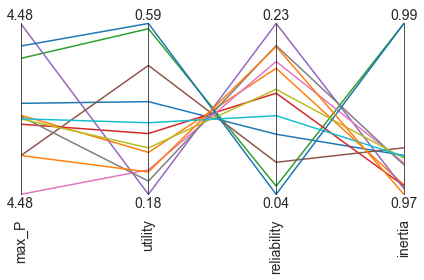

In [17]:
outcomes = results_Max_P.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P')

Text(0.5, 0, 'number of function evaluations')

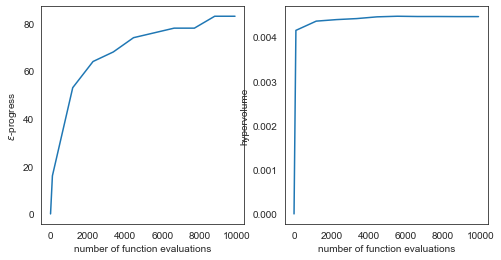

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence_Max_P.nfe, convergence_Max_P.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence_Max_P.nfe, convergence_Max_P.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

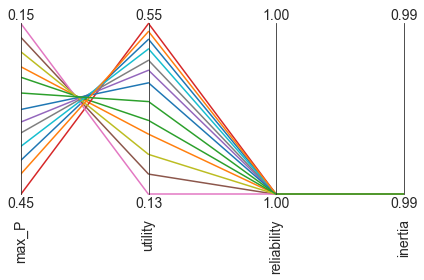

In [19]:
outcomes = results_Utility.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P')

Text(0.5, 0, 'number of function evaluations')

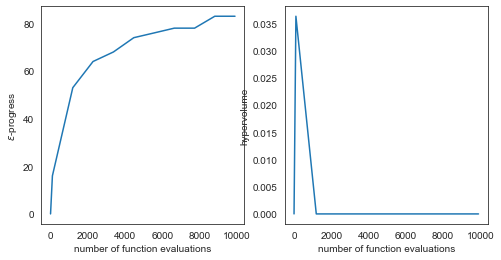

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence_Utility.nfe, convergence_Max_P.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence_Utility.nfe, convergence_Utility.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

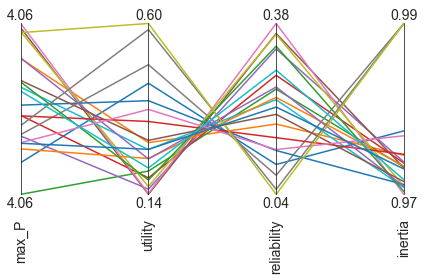

In [21]:
outcomes = results_Inertia.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P')

Text(0.5, 0, 'number of function evaluations')

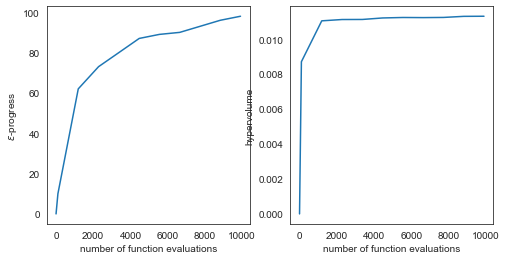

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence_Intertia.nfe, convergence_Intertia.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence_Intertia.nfe, convergence_Intertia.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

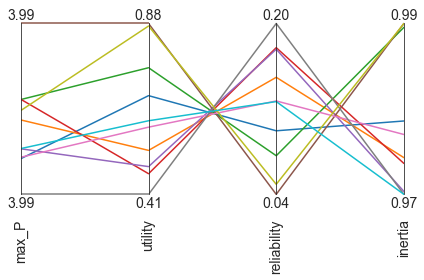

In [23]:
outcomes = results_Reliability.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P')

Text(0.5, 0, 'number of function evaluations')

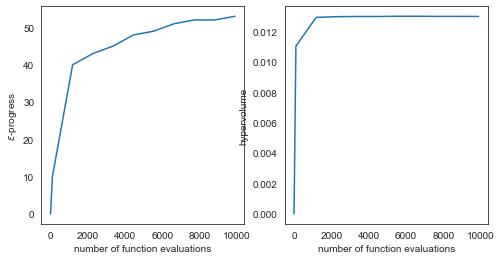

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence_Reliability.nfe, convergence_Reliability.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence_Reliability.nfe, convergence_Reliability.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


There are over 50 policies, so to take the most interesting one we will take the max 5 and min 5 for each objective from the dataframe
The method for choosing scenarios was to look for the most vulnerable scenarios for each of the outcomes. This was the directed search method. Therefore, the outcomes of assignment 8 were sorted, and for the worst scenario for each of the for outcomes was made as its own reference scenario.

In [25]:
results_Reliability

combined_solutions = pd.concat([results_Max_P, results_Utility, results_Inertia, results_Reliability], axis = 0)

max_max_P = combined_solutions.sort_values(by = 'max_P').iloc[0:7]
min_max_P = combined_solutions.sort_values(by = 'max_P', ascending = True).iloc[0:7]

max_utility = combined_solutions.sort_values(by = 'utility').iloc[0:7]
min_utility = combined_solutions.sort_values(by = 'utility', ascending = True).iloc[0:7]

max_inertia = combined_solutions.sort_values(by = 'inertia').iloc[0:7]
min_inertia = combined_solutions.sort_values(by = 'inertia', ascending = True).iloc[0:7]

max_reliability = combined_solutions.sort_values(by = 'reliability').iloc[0:7]
min_reliability = combined_solutions.sort_values(by = 'reliability', ascending = True).iloc[0:7]

new_combined_solutions = pd.concat([max_max_P,min_max_P,max_utility,min_utility,max_inertia,min_inertia,max_reliability,min_reliability], axis = 0)

In [26]:
new_solutions = new_combined_solutions.drop_duplicates()

In [28]:
new_solutions

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
6,0.320441,0.294923,1.908566,0.637583,0.073168,0.149490,0.132677,0.9900,1.0000
5,0.391035,0.276541,0.705308,0.407605,0.249684,0.173600,0.182126,0.9900,1.0000
8,0.367160,0.391720,0.774890,0.586054,0.308904,0.198782,0.230289,0.9900,1.0000
1,0.266365,0.479250,1.458935,0.704302,0.220539,0.224953,0.279732,0.9900,1.0000
2,0.479495,0.468991,0.670561,1.747279,0.971887,0.243295,0.313232,0.9900,1.0000
12,0.348754,-0.719738,0.321240,1.302114,0.913318,0.270846,0.359322,0.9900,1.0000
10,1.618175,0.533620,1.910927,0.681047,0.066964,0.299618,0.405100,0.9900,1.0000
5,-0.167157,0.280249,1.654762,0.788136,0.768870,4.058754,0.136576,0.9752,0.3631
6,0.198343,0.485368,0.601069,1.876542,0.713263,4.058741,0.138690,0.9725,0.3832
4,-0.095023,0.162425,1.083781,1.269627,0.498329,4.059067,0.150818,0.9758,0.3320


In [ ]:
new_solutions.to_csv('new_solutions.csv', index = False)

In [5]:
new_solutions = pd.read_csv('new_solutions.csv')

In [7]:
new_solutions.head()

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.320441,0.294923,1.908566,0.637583,0.073168,0.149490,0.132677,0.99,1.0
1,0.391035,0.276541,0.705308,0.407605,0.249684,0.173600,0.182126,0.99,1.0
2,0.367160,0.391720,0.774890,0.586054,0.308904,0.198782,0.230289,0.99,1.0
3,0.266365,0.479250,1.458935,0.704302,0.220539,0.224953,0.279732,0.99,1.0
4,0.479495,0.468991,0.670561,1.747279,0.971887,0.243295,0.313232,0.99,1.0


In [8]:
from ema_workbench import Policy

#Create a collection of all the policies
new_policies = []

#Iterate over the new results table
for i in range(len(new_solutions)):
    new_policy = Policy(name="Policy " + str(i), 
                        c1 = new_solutions.iloc[i,0] , 
                        c2 = new_solutions.iloc[i,1], 
                        r1 = new_solutions.iloc[i,2], 
                        r2 = new_solutions.iloc[i,3], 
                        w1 = new_solutions.iloc[i,4])
    new_policies.append(new_policy)

new_policies

[Policy({'c1': 0.320441000137789, 'c2': 0.29492261947339904, 'r1': 1.9085655942496755, 'r2': 0.6375825438920633, 'w1': 0.07316835467879729}),
 Policy({'c1': 0.3910349131972666, 'c2': 0.2765409583956401, 'r1': 0.7053080133017371, 'r2': 0.4076048663767747, 'w1': 0.2496839752328795}),
 Policy({'c1': 0.3671596221419901, 'c2': 0.3917197113978118, 'r1': 0.7748900680631092, 'r2': 0.5860544964304397, 'w1': 0.3089043511942593}),
 Policy({'c1': 0.26636479352646825, 'c2': 0.479249523972781, 'r1': 1.4589345998570955, 'r2': 0.7043015456197768, 'w1': 0.22053861548302267}),
 Policy({'c1': 0.4794950308498205, 'c2': 0.4689907968715824, 'r1': 0.6705612804391088, 'r2': 1.7472794601667632, 'w1': 0.9718867235905017}),
 Policy({'c1': 0.3487543491102474, 'c2': -0.719738370426525, 'r1': 0.3212401740128108, 'r2': 1.3021144495136516, 'w1': 0.9133183641230704}),
 Policy({'c1': 1.6181748039660948, 'c2': 0.5336197003093247, 'r1': 1.910927029955361, 'r2': 0.6810469780906516, 'w1': 0.06696381450706454}),
 Policy({'c

In [12]:
# Run for 1000 scenarios for all policies

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(mordm_lake_model) as evaluator:
    new_experiments, new_outcomes = evaluator.perform_experiments(scenarios=1000, policies=new_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 25 policies * 1 model(s) = 25000 experiments
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 7500 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 12500 cases completed
[MainProcess/INFO] 15000 cases completed
[MainProcess/INFO] 17500 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 22500 cases completed
[MainProcess/INFO] 25000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


In [13]:
maximum_regret = pd.DataFrame(columns=["Policy", "Utility MR", "Intertia MR", "Reliability MR"])

#Iterate over all policies
for policy in new_experiments["policy"].unique():

    MR_max_P, MR_utility, MR_inertia, MR_reliability = 0,0,0,0

    #Iterate over all Scenarios
    for scenario in new_experiments["scenario"].unique():
        #Get indices
        scenario_indices = new_experiments[new_experiments["scenario"] == scenario].index
        policy_index = new_experiments[(new_experiments["scenario"] == scenario) & (new_experiments["policy"] == policy)].index 

        #Utility, Should be maximized
        MR_utility = max(MR_utility, new_outcomes["utility"][scenario_indices].max() - new_outcomes["utility"][policy_index])

        #Inertia, Should be maximized
        MR_inertia = max(MR_inertia, new_outcomes["inertia"][scenario_indices].max() - new_outcomes["inertia"][policy_index])

        #Reliability, Should be maximized
        MR_reliability = max(MR_reliability, new_outcomes["reliability"][scenario_indices].max() - new_outcomes["reliability"][policy_index])

    maximum_regret = maximum_regret.append(pd.DataFrame(index=np.arange(1), data = {"Policy" : policy, "Utility MR": MR_utility, "Intertia MR": MR_inertia, "Reliability MR": MR_reliability}))
maximum_regret

,Policy,Utility MR,Intertia MR,Reliability MR
0,Policy 0,2.166280,0.0200,0.1896
0,Policy 1,2.146953,0.0200,0.4497
0,Policy 2,2.072354,0.0200,0.7342
0,Policy 3,1.968433,0.0200,0.8885
0,Policy 4,1.937824,0.0200,0.9177
0,Policy 5,1.221206,0.0199,0.9501
0,Policy 6,1.541080,0.0200,0.9538
0,Policy 7,2.242040,0.0200,0.7460
0,Policy 8,2.231593,0.0200,0.5033
0,Policy 9,2.242509,0.0200,0.8111


<Figure size 432x288 with 0 Axes>

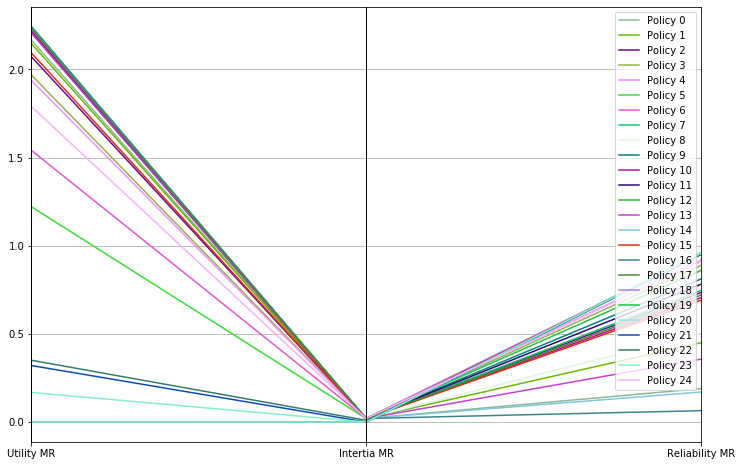

In [14]:
%matplotlib inline
plt.figure()
fig= plt.figure(figsize=(12,8))
pd.plotting.parallel_coordinates(maximum_regret, "Policy")
plt.show()

In [66]:
new_outcomes.keys()

dict_keys(['max_P', 'utility', 'inertia', 'reliability'])

In [15]:
all_data = pd.concat([new_experiments, pd.DataFrame(new_outcomes)], axis = 1)
all_data

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model,max_P,utility,inertia,reliability
0,0.358142,0.937871,0.026746,2.477120,0.002718,0.320441,0.294923,1.908566,0.637583,0.073168,0,Policy 0,lakeproblem,0.135915,0.160351,0.9900,1.0000
1,0.126358,0.986030,0.019207,3.556854,0.002205,0.320441,0.294923,1.908566,0.637583,0.073168,1,Policy 0,lakeproblem,8.844792,1.002489,0.9731,0.4366
2,0.181769,0.948549,0.044567,3.558365,0.003393,0.320441,0.294923,1.908566,0.637583,0.073168,2,Policy 0,lakeproblem,6.289588,0.364375,0.9716,0.2085
3,0.102809,0.969393,0.011983,2.389790,0.004259,0.320441,0.294923,1.908566,0.637583,0.073168,3,Policy 0,lakeproblem,10.782383,0.914354,0.9740,0.0574
4,0.196805,0.984151,0.017176,3.973786,0.004513,0.320441,0.294923,1.908566,0.637583,0.073168,4,Policy 0,lakeproblem,0.149321,0.307353,0.9900,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.166043,0.949063,0.034520,3.473453,0.003122,-0.517801,0.218363,1.998606,0.216033,0.549169,995,Policy 24,lakeproblem,6.825891,0.678050,0.9763,0.0802
24996,0.167622,0.945495,0.013679,4.188915,0.001439,-0.517801,0.218363,1.998606,0.216033,0.549169,996,Policy 24,lakeproblem,6.642053,0.469770,0.9769,0.2172
24997,0.321843,0.989747,0.019510,2.315582,0.004125,-0.517801,0.218363,1.998606,0.216033,0.549169,997,Policy 24,lakeproblem,3.294605,2.047475,0.9762,0.2210
24998,0.284573,0.953188,0.043614,3.736938,0.002654,-0.517801,0.218363,1.998606,0.216033,0.549169,998,Policy 24,lakeproblem,3.999861,0.648368,0.9769,0.1670


In [16]:
policy_subset = []

for i in range(25):
    policy_subset.append(all_data[all_data['policy'] == 'Policy ' + str(i)]) 

In [17]:
policy_subset[2]

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model,max_P,utility,inertia,reliability
2000,0.358142,0.937871,0.026746,2.477120,0.002718,0.36716,0.39172,0.77489,0.586054,0.308904,0,Policy 2,lakeproblem,0.201797,0.249030,0.9900,1.0000
2001,0.126358,0.986030,0.019207,3.556854,0.002205,0.36716,0.39172,0.77489,0.586054,0.308904,1,Policy 2,lakeproblem,8.852201,1.229785,0.9721,0.3245
2002,0.181769,0.948549,0.044567,3.558365,0.003393,0.36716,0.39172,0.77489,0.586054,0.308904,2,Policy 2,lakeproblem,6.290059,0.399122,0.9720,0.1849
2003,0.102809,0.969393,0.011983,2.389790,0.004259,0.36716,0.39172,0.77489,0.586054,0.308904,3,Policy 2,lakeproblem,10.783369,1.033999,0.9746,0.0200
2004,0.196805,0.984151,0.017176,3.973786,0.004513,0.36716,0.39172,0.77489,0.586054,0.308904,4,Policy 2,lakeproblem,0.213291,0.541911,0.9900,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.166043,0.949063,0.034520,3.473453,0.003122,0.36716,0.39172,0.77489,0.586054,0.308904,995,Policy 2,lakeproblem,6.826314,0.364704,0.9719,0.2175
2996,0.167622,0.945495,0.013679,4.188915,0.001439,0.36716,0.39172,0.77489,0.586054,0.308904,996,Policy 2,lakeproblem,0.216475,0.242715,0.9900,1.0000
2997,0.321843,0.989747,0.019510,2.315582,0.004125,0.36716,0.39172,0.77489,0.586054,0.308904,997,Policy 2,lakeproblem,0.214404,0.642764,0.9900,1.0000
2998,0.284573,0.953188,0.043614,3.736938,0.002654,0.36716,0.39172,0.77489,0.586054,0.308904,998,Policy 2,lakeproblem,0.227748,0.229625,0.9900,1.0000


In [18]:
# Outcome	Goal	Threshold
# Pollution level	Minimize	Critical pollution level
# Utility	Maximize	0.75
# Inertia	Maximize	0.99
# Reliability	Maximize	0.8

domain_criterion = pd.DataFrame(columns = ['Policy', 'Utility', 'Inertia', 'Reliability'])
domain = []
count_utility = 0
count_inertia = 0
count_reliability = 0

for i in range(25):
    for j in range(1000):
        if policy_subset[i]['utility'].iloc[j] > 0.75:
            count_utility += 1
        if policy_subset[i]['inertia'].iloc[j] > 0.99:
            count_inertia += 1
        if policy_subset[i]['reliability'].iloc[j] > 0.8:
            count_reliability += 1
    criterion_utility = count_utility/1000
    criterion_inertia = count_inertia/1000
    criterion_reliability = count_reliability/1000
    
    new_row = {'Policy':'Policy ' + str(i), 'Utility':criterion_utility, 'Inertia':criterion_inertia, 'Reliability':criterion_reliability}
    
    domain_criterion = domain_criterion.append(new_row, ignore_index = True)
    count_utility = 0
    count_inertia = 0
    count_reliability = 0
    
domain_criterion

,Policy,Utility,Inertia,Reliability
0,Policy 0,0.125,0.665,0.680
1,Policy 1,0.162,0.653,0.677
2,Policy 2,0.195,0.656,0.672
3,Policy 3,0.248,0.636,0.647
4,Policy 4,0.282,0.620,0.636
5,Policy 5,0.522,0.310,0.345
6,Policy 6,0.440,0.491,0.503
7,Policy 7,0.132,0.623,0.640
8,Policy 8,0.125,0.661,0.675
9,Policy 9,0.148,0.588,0.604


<Figure size 432x288 with 0 Axes>

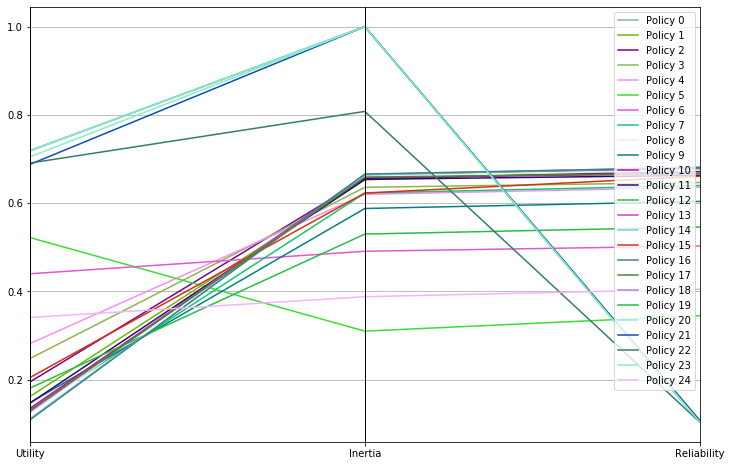

In [19]:
plt.figure()
fig= plt.figure(figsize=(12,8))
pd.plotting.parallel_coordinates(domain_criterion, "Policy")